# MTMount accelerometers
Querying MTMount accelerometers \
Craig Lage - 22-Mar-23 \
Edited by Elana Urbach

In [38]:
import sys, time, os, asyncio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from astropy.time import Time, TimeDelta
from scipy.interpolate import UnivariateSpline
from lsst_efd_client.efd_helper import EfdClient, merge_packed_time_series

In [12]:
# Get EFD client
client = EfdClient('summit_efd')

In [13]:
# Times to look at the data
# start = Time("2023-03-22 08:00:00Z", scale='utc')
# end = Time("2023-03-22 08:10:00Z", scale='utc')

start = Time("2023-03-22 08:00:00Z", scale='utc')
end = Time("2023-03-22 08:30:00Z", scale='utc')


In [14]:
baseFields = ['accelerationX', 'accelerationY', 'accelerationZ']
sensorNames = ['SST top end ring +x -y', 'SST top end ring -x -y', 'SST spider spindle', 'SST M2 surrogate'] 
TMA_coords_mm = [[3876, -3696, 4653], [-3786, -3786, 4653], [-1275, 602, 5383], [-1882, 0, 4342]]

##  Get all of the data for the selected times

In [5]:
packed_dataframe = await client.select_time_series("lsst.sal.ESS.accelerometer", ["*"], start, end)
az = await client.select_time_series('lsst.sal.MTMount.azimuth', \
                                        ['actualPosition', 'timestamp'],  start, end)
el = await client.select_time_series('lsst.sal.MTMount.elevation', \
                                        ['actualPosition', 'timestamp'],  start, end)

## Now unpack it and plot it by sensor

In [37]:
 
start = Time("2023-03-25T01:26:29", scale='utc')
end = Time("2023-03-25T01:46:02", scale='utc')

packed_dataframe = await client.select_time_series("lsst.sal.ESS.accelerometer", ["*"], start, end)
az = await client.select_time_series('lsst.sal.MTMount.azimuth', \
                                            ['*'],  start, end)
el = await client.select_time_series('lsst.sal.MTMount.elevation', \
                                            ['*'],  start, end)    

In [121]:
smoothingFactor = 0.2 # In spline creation
kernel_size = 100 # In convolution
kernel = np.ones(kernel_size) / kernel_size



azPs = az['actualPosition'].values
azVs = az['actualVelocity'].values
azXs = az['timestamp'].values - az['timestamp'].values[0]  
elPs = el['actualPosition'].values
elVs = el['actualVelocity'].values
elXs = el['timestamp'].values - el['timestamp'].values[0]
plotStart = azXs[0] + 1.0
plotEnd = azXs[-1] - 1.0
    
    
plotAzXs = np.linspace(azXs[0], azXs[-1], len(azXs)*100)
plotElXs = np.linspace(elXs[0], elXs[-1], len(elXs)*100)
azPSpline = UnivariateSpline(azXs, azPs, s=0)
azVelSpline1 = UnivariateSpline(azXs, azVs, s=0) 
#azVelSpline1 =azPSpline.derivative(n=1)
# Now smooth the derivative before differentiating again
smoothedAzVel = np.convolve(azVelSpline1(plotAzXs), kernel, mode='same')
azVelSpline = UnivariateSpline(plotAzXs, smoothedAzVel, s=smoothingFactor)
azAccSpline1 = azVelSpline.derivative(n=1)
smoothedAzAcc = np.convolve(azAccSpline1(plotAzXs), kernel, mode='same')
# Now smooth the derivative before differentiating again
azAccSpline = UnivariateSpline(plotAzXs, smoothedAzAcc, s=smoothingFactor)
azJerkSpline = azAccSpline.derivative(n=1) 
elPSpline = UnivariateSpline(elXs, elPs, s=0)
elVelSpline1 = UnivariateSpline(elXs, elVs, s=0)
#elVelSpline1 =elPSpline.derivative(n=1)
# Now smooth the derivative before differentiating again
smoothedElVel = np.convolve(elVelSpline1(plotElXs), kernel, mode='same')
elVelSpline = UnivariateSpline(plotElXs, smoothedElVel, s=smoothingFactor)
elAccSpline1 = elVelSpline.derivative(n=1)
smoothedElAcc = np.convolve(elAccSpline1(plotElXs), kernel, mode='same')
# Now smooth the derivative before differentiating again
elAccSpline = UnivariateSpline(plotElXs, smoothedElAcc, s=smoothingFactor)
elJerkSpline = elAccSpline.derivative(n=1) 

0.17155393053016454
234600
1367500


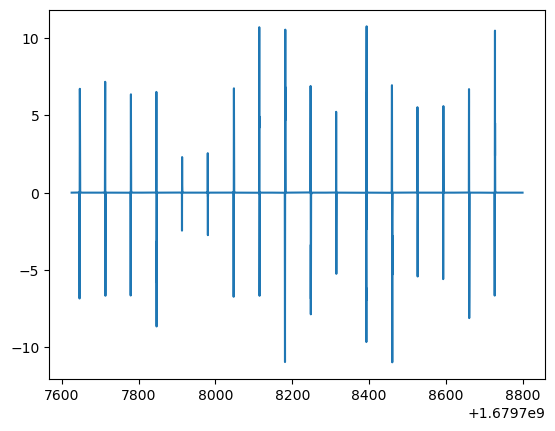

In [123]:
plt.plot(plotAzXs + az['timestamp'].values[0], azAccSpline(plotAzXs), label = 'Mt encoder')


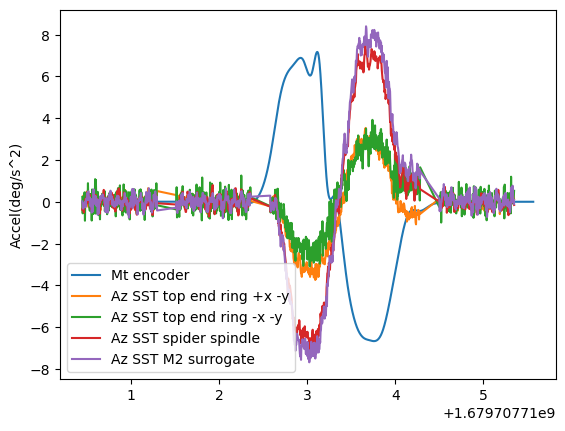

In [124]:
# convert to degrees/s
g = 9.5


plt.figure()

mt_encoder_times = plotAzXs + az['timestamp'].values[0]
plt.plot(mt_encoder_times[(df.times[17000] < mt_encoder_times) & (df.times[18000] > mt_encoder_times)],\
         azAccSpline(plotAzXs[(df.times[17000] < mt_encoder_times) & (df.times[18000] > mt_encoder_times)]), label = 'Mt encoder')
# plt.plot(mt_encoder_times[(df.times[17000] < mt_encoder_times) & (df.times[18000] > mt_encoder_times)],\
#          elAccSpline(plotElXs[(df.times[17000] < mt_encoder_times) & (df.times[18000] > mt_encoder_times)]), label = 'Mt encoder')


for i, sensorName in enumerate(sensorNames):
    sub_dataframe = packed_dataframe.loc[packed_dataframe.sensorName==sensorName]
    elevations = np.array(el.actualPosition[np.argmin(np.abs(np.subtract(np.array(el.timestamp), \
                                np.expand_dims(np.array(sub_dataframe.timestamp), 0).T)), axis = 1)])
    theta = np.arctan(TMA_coords_mm[i][1] / TMA_coords_mm[i][2])
    r_theta = np.sqrt(TMA_coords_mm[i][2]**2 + TMA_coords_mm[i][1]**2) * 10**-3
    r_phi = np.sqrt(TMA_coords_mm[i][2]**2 + TMA_coords_mm[i][1]**2 + TMA_coords_mm[i][0]**2) * 10**-3
    plt.ylabel("Accel(deg/s^2)")
    unpacked_elevations = np.repeat(elevations, 200)
    r_phi_axis = np.sqrt((TMA_coords_mm[i][2] * np.cos(unpacked_elevations * np.pi/180) \
                          - TMA_coords_mm[i][1] * np.sin(unpacked_elevations * np.pi/180))**2 \
                          + TMA_coords_mm[i][0]**2) * 10**-3 # not sure - or + for [1]
   
    for j, baseField in enumerate(baseFields):
        df = merge_packed_time_series(sub_dataframe, baseField, stride=1,
                             ref_timestamp_col="timestamp", fmt='unix_tai',
                             scale='tai')
        if j == 0:
            az_el_accel_df = pd.DataFrame(data = {'AccelerationElevation': np.zeros(len(df.index)), 'AccelerationAzimuth': np.zeros(len(df.index))})
            # az_el_accel_df['times'] = [Time(df.times[i], format='unix_tai', scale='utc') for i in range(len(df.times))]
        if baseField == 'accelerationY' or baseField == 'accelerationZ':
            if baseField == 'accelerationY':
                df['accelerationY'] = df['accelerationY'] - g * np.cos(unpacked_elevations * np.pi / 180)
                az_el_accel_df['AccelerationElevation'] += +1 * (np.array(df['accelerationY']) * TMA_coords_mm[i][2] * 10**-3/ (r_theta**2)) * 180/np.pi
                
                az_el_accel_df['AccelerationAzimuth'] += +1 * (np.array(df['accelerationY']) * np.sin(unpacked_elevations * np.pi/180) \
                                                            * (TMA_coords_mm[i][0]) * 10**-3 / (r_phi_axis**2)) * 180/np.pi

            else:
                df['accelerationZ'] = df['accelerationZ'] - g * np.sin(unpacked_elevations * np.pi / 180)
                az_el_accel_df['AccelerationElevation'] += -1 * (np.array(df['accelerationZ']) * TMA_coords_mm[i][1] * 10**-3/ (r_theta**2)) * 180/np.pi 
                
                az_el_accel_df['AccelerationAzimuth'] += -1 * (np.array(df['accelerationZ']) * np.cos(unpacked_elevations * np.pi/180) \
                                                               * (TMA_coords_mm[i][0]) * 10**-3 / (r_phi_axis**2)) * 180/np.pi

        else:
            az_el_accel_df['AccelerationAzimuth'] += +1 * (np.array(df['accelerationX']) * (TMA_coords_mm[i][2] * np.cos(unpacked_elevations * np.pi/180) \
                          - TMA_coords_mm[i][1] * np.sin(unpacked_elevations * np.pi/180)) * 10**-3/ (r_phi_axis**2)) * 180/np.pi


    # plt.plot(df.times[17000:18000], az_el_accel_df['AccelerationElevation'][17000:18000] - az_el_accel_df['AccelerationElevation'][17000:17100].mean(), label='El ' + str(sensorName))
    plt.plot(df.times[17000:18000], az_el_accel_df['AccelerationAzimuth'][17000:18000] - az_el_accel_df['AccelerationAzimuth'][17000:17100].mean(), label='Az ' + str(sensorName))
    # 3800:4700, 17000:18000
    # az_el_accel_df['AccelerationElevation'].plot(label='El ' + str(sensorName))
    # az_el_accel_df['AccelerationAzimuth'].plot(label='Azimuth')
    plt.legend()


